In [31]:
"""
error_analysis.py

This script performs error analysis on result JSON files generated by any of the approaches.
It uses the shared analyze_errors() function from factchecker_base.
"""

import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
import os
import re

# Save and Load Functions

In [52]:
def save_to_json(data, file_path):
    """
    Save a list of dictionaries to a JSON file.
    """
    try:
        with open(file_path, "w") as json_file:
            json.dump(data, json_file, indent=2)
        print(f"Data saved to {file_path}")
    except Exception as e:
        print(f"Error saving data to {file_path}: {e}")

def load_json(file_path):
    """
    Load a JSON file containing a list of dictionaries.
    """
    try:
        with open(file_path, "r") as json_file:
            data = json.load(json_file)
        return data
    except Exception as e:
        print(f"Error loading JSON file: {e}")
        return []


In [ ]:
def load_accuracies_from_folder(folder_path):
    accuracies = []  # List to store accuracies
    filenames = []   # List to store the filenames
    
    # Iterate through files in the folder
    for filename in os.listdir(folder_path):
        if filename.startswith('results') and filename.endswith('.json'):
            file_path = os.path.join(folder_path, filename)
            
            # Load predictions from JSON file
            with open(file_path, 'r') as file:
                predictions = json.load(file)
                
                # Append accuracy and filename
                accuracies.append(accuracy(predictions))
                filenames.append(filename)
    
    return accuracies, filenames

# Example usage
folder_path = '../docs/results'  # Replace with the path to your folder
accuracies, filenames = load_accuracies_from_folder(folder_path)
sorted_accuracies, sorted_filenames = zip(*sorted(zip(accuracies, filenames), reverse=True))

# Print the accuracies and filenames
for acc, filename in zip(sorted_accuracies, sorted_filenames):
    print(f"Accuracy: {acc:.2f}%, Filename: {filename}")

In [ ]:
'../docs/results/results_with_cells_phi4:latest_test_examples_1695_zero_shot_naturalized.json'
'../docs/results/results_with_cells_phi4:latest_test_examples_1695_zero_shot_markdown.json'
'../docs/results/results_with_cells_phi4:latest_test_examples_1105_chain_of_thought_naturalized.json'
'../docs/results/results_with_cells_deepseek-r1:32b_test_examples_686_zero_shot_naturalized.json'
'../docs/results/results_with_cells_deepseek-r1:8b_test_examples_1695_zero_shot_markdown.json'
'../docs/results/results_with_cells_mistral:latest_test_examples_1695_chain_of_thought_naturalized.json'
'../docs/results/results_with_cells_llama3.2:latest_test_examples_325_chain_of_thought_naturalized.json'
'results_CodeGeneration_test_examples_zero_shot_naturalized_phi4.json'

In [78]:
folder_path = 'results_20250215'  # Replace with the path to your folder
accuracies, filenames = load_accuracies_from_folder(folder_path)
sorted_accuracies, sorted_filenames = zip(*sorted(zip(accuracies, filenames), reverse=True))

# Print the accuracies and filenames
for acc, filename in zip(sorted_accuracies, sorted_filenames):
    print(f"Accuracy: {acc:.2f}%, Filename: {filename}")

Accuracy: 64.38%, Filename: results_prompt_engineering_test_examples_chain_of_thought_naturalized_mistral:latest.json
Accuracy: 63.49%, Filename: results_prompt_engineering_test_examples_chain_of_thought_markdown_mistral:latest.json
Accuracy: 62.16%, Filename: results_prompt_engineering_test_examples_chain_of_thought_html_mistral:latest.json
Accuracy: 61.17%, Filename: results_prompt_engineering_test_examples_chain_of_thought_json_mistral:latest.json


In [59]:
def top_10_accuracies(accuracies, filenames):
    # Combine accuracies and filenames into a list of tuples
    accuracy_filename_pairs = list(zip(accuracies, filenames))
    
    # Sort the list by accuracy in descending order
    sorted_accuracy_filename_pairs = sorted(accuracy_filename_pairs, key=lambda x: x[0], reverse=True)
    
    # Get the top 10 accuracies and filenames
    top_10 = sorted_accuracy_filename_pairs[:10]
    
    # Separate the top 10 accuracies and filenames
    top_10_accuracies = [pair[0] for pair in top_10]
    top_10_filenames = [pair[1] for pair in top_10]
    
    return top_10_accuracies, top_10_filenames

# Example usage
top_10_accuracies_list, top_10_filenames_list = top_10_accuracies(accuracies, filenames)

# Print the results
print("Top 10 Accuracies:")
for acc, name in zip(top_10_accuracies_list, top_10_filenames_list):
    print(f"{name}: {acc:.2f}%")

Top 10 Accuracies:
results_with_cells_phi4:latest_test_examples_1695_zero_shot_naturalized.json: 88.93%
results_with_cells_phi4:latest_test_examples_1695_zero_shot_markdown.json: 88.58%
results_with_cells_phi4:latest_test_examples_1105_chain_of_thought_naturalized.json: 87.59%
results_with_cells_phi4:latest_test_examples_1695_zero_shot_json.json: 87.23%
results_with_cells_phi4:latest_test_examples_1089_chain_of_thought_markdown.json: 87.08%
results_with_cells_phi4:latest_test_examples_1695_zero_shot_html.json: 86.30%
results_with_cells_deepseek-r1:32b_test_examples_686_zero_shot_naturalized.json: 85.53%
results_with_cells_deepseek-r1:32b_test_examples_687_zero_shot_markdown.json: 85.32%
results_with_cells_phi4:latest_test_examples_1071_chain_of_thought_json.json: 84.95%
results_with_cells_phi4:latest_test_examples_1073_chain_of_thought_html.json: 84.38%


In [60]:
def transform_filenames(filenames):
    transformed_filenames = []

    # Define the pattern to match the unwanted parts of the filename
    pattern = r"results_with_cells[:]?([\w\-]+)(?:[:]\w+)?_test_examples_\d+_(.*)\.json"

    # Iterate through each filename and apply the transformation
    for filename in filenames:
        match = re.match(pattern, filename)
        if match:
            model = match.group(1).lstrip('_')  # Remove the leading underscore from the model
            prompt_engineering = match.group(2)  # Extract the prompt engineering part
            transformed_filename = f"{model} {prompt_engineering.replace('_', ' ')}"
            transformed_filenames.append(transformed_filename)
        else:
            # If the filename does not match the expected pattern, append it as is
            transformed_filenames.append(filename)

    return transformed_filenames



top_10_filenames_list = transform_filenames(top_10_filenames_list)
for f in top_10_filenames_list:
    print(f)

phi4 zero shot naturalized
phi4 zero shot markdown
phi4 chain of thought naturalized
phi4 zero shot json
phi4 chain of thought markdown
phi4 zero shot html
deepseek-r1 zero shot naturalized
deepseek-r1 zero shot markdown
phi4 chain of thought json
phi4 chain of thought html


In [61]:
def load_top_10_files(accuracies, filenames, folder_path):
    # Get the top 10 accuracies and corresponding filenames
    top_10_accuracies_list, top_10_filenames_list = top_10_accuracies(accuracies, filenames)
    
    top_10_files_data = []  # List to store the data of the top 10 files

    # Load the predictions from each of the top 10 files
    for filename in top_10_filenames_list:
        file_path = os.path.join(folder_path, filename)
        
        # Open the JSON file and load its content into a list of dictionaries
        with open(file_path, 'r') as file:
            file_data = json.load(file)
            top_10_files_data.append(file_data)
    
    return top_10_files_data

# Example usage
top_10_files_data = load_top_10_files(accuracies, filenames, folder_path)

In [ ]:
model_path_names = []

# Plot Functions

In [62]:
def accuracy(predictions):
    
    correct_predictions = sum(1 for p in predictions if p['true_response'] == p['predicted_response'])
    total_predictions = len(predictions)

    accuracy = (correct_predictions / total_predictions) * 100

    return (accuracy)

## Plot Misclassifications per categories

In [63]:
def calculate_misclassifications(predictions, categorised_claims, category_misclassifications):
    """
    Calculates the misclassification percentage for each category, based on the new structure where
    true_response is in the predictions.

    Args:
    - predictions (list of dicts): Predictions made by the model.
    - categorised_claims (list of dicts): Claims categorized under different labels.

    Returns:
    - dict: A dictionary with categories as keys and misclassification percentages as values.
    """
    # Initialize counters for total claims and misclassifications per category
    category_counts = {category: 0 for category in category_misclassifications}
    category_misclassifications = {category: 0 for category in category_misclassifications}

    for prediction in predictions:
        claim = prediction["claim"]
        true_response = prediction["true_response"]
        predicted_response = prediction["predicted_response"]
        
        # Find the claim in the categorised_claims
        claim_data = next((item for item in categorised_claims if item["claim"] == claim), None)
        
        if claim_data:
            # Check if the prediction is misclassified
            is_misclassified = true_response != predicted_response

            # Loop through each category in the claim and update misclassification counts
            for category in category_counts:
                if category in claim_data and claim_data[category]:
                    # If the claim is part of the category, update the counts
                    category_counts[category] += 1
                    if is_misclassified:
                        category_misclassifications[category] += 1

    # Calculate the percentage of misclassifications for each category
    category_percentages = {
        category: (category_misclassifications[category] / category_counts[category] * 100)
        if category_counts[category] > 0 else 0
        for category in category_counts
    }

    return category_percentages

In [64]:
def plot_misclassifications(category_percentages):
    """
    Plots the misclassification percentages for each category.

    Args:
    - category_percentages (dict): A dictionary with categories as keys and misclassification percentages as values.
    """
    categories = list(category_percentages.keys())
    percentages = list(category_percentages.values())
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(categories, percentages, color='r')
    ax.set_xlabel('Categories')
    ax.set_ylabel('Misclassification Percentage (%)')
    ax.set_title('Misclassification Percentage per Category')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [65]:
def plot_misclassifications_with_overall_misclassification(category_percentages, predictions):
    """
    Plots the misclassification percentages for each category and adds a dashed horizontal line 
    representing the overall accuracy of the classifications.

    Args:
    - category_percentages (dict): A dictionary with categories as keys and misclassification percentages as values.
    - predictions (list of dicts): Predictions made by the model.
    """
    categories = list(category_percentages.keys())
    percentages = list(category_percentages.values())

    # Compute overall accuracy
    total_predictions = len(predictions)
    total_misclassifications = sum(1 for p in predictions if p["true_response"] != p["predicted_response"])
    overall_accuracy = total_misclassifications / total_predictions * 100

    # Plot histogram
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(categories, percentages, color='r', alpha=0.7, label='Misclassification %')

    # Add horizontal line for overall accuracy
    ax.axhline(y=overall_accuracy, color='b', linestyle='dashed', linewidth=2, label=f'Overall Misclassification Rate: {overall_accuracy:.2f}%')

    # Labels and title
    ax.set_xlabel('Categories')
    ax.set_ylabel('Misclassification Percentage (%)')
    ax.set_title('Misclassification Percentage per Category')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


## Plot category co-occurences

In [66]:
def plot_category_cooccurrence(categorised_claims):
    # Extract all unique categories
    categories = set()
    for claim in categorised_claims:
        categories.update(claim.keys())
    categories.discard("ID")  # Remove non-category fields
    categories.discard("claim")
    
    # Initialize co-occurrence matrix
    category_list = sorted(categories)
    cooccurrence_matrix = pd.DataFrame(0, index=category_list, columns=category_list)
    
    # Populate co-occurrence matrix
    for claim in categorised_claims:
        active_categories = [cat for cat in category_list if claim.get(cat, False)]
        for i in range(len(active_categories)):
            for j in range(i, len(active_categories)):
                cooccurrence_matrix.loc[active_categories[i], active_categories[j]] += 1
                if i != j:
                    cooccurrence_matrix.loc[active_categories[j], active_categories[i]] += 1
    
    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cooccurrence_matrix, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
    plt.title("Category Co-occurrence Heatmap")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()

## Count claims per categories

In [67]:
def count_claims_per_category(categorised_claims):
    # Initialize a defaultdict to store counts for each category
    category_counts = defaultdict(int)
    
    # Loop through each claim in categorised_claims
    for claim_data in categorised_claims:
        # Loop through each key in the claim (excluding ID and claim text)
        for category, is_present in claim_data.items():
            # Only count if the category is a boolean and is True
            if category != "ID" and category != "claim" and is_present:
                category_counts[category] += 1
    
    return category_counts

def plot_category_counts(category_counts):
    # Create a bar plot for category counts
    categories = list(category_counts.keys())
    counts = list(category_counts.values())
    
    # Create the bar plot
    bars = plt.bar(categories, counts, color='skyblue')
    
    # Add labels and title
    plt.xlabel('Categories')
    plt.ylabel('Number of Claims')
    plt.title('Number of Claims per Category')
    plt.xticks(rotation=45, ha="right")
    
    # Annotate each bar with the count value
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, str(yval), ha='center', va='bottom')
    
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

## Assess performance of multiple models

In [72]:
def plot_comparison(model_errors_list, accuracy_list, model_names):
    # Define categories (keys in the dictionaries)
    categories = list(model_errors_list[0].keys())  # Assuming all models have the same categories
    
    # Create x positions for the bars
    x = np.arange(len(categories))
    
    # Set width of bars
    width = 0.8 / len(model_errors_list)  # Adjust width based on the number of models
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot bars for each model
    for i, (model_errors, accuracy, model_name) in enumerate(zip(model_errors_list, accuracy_list, model_names)):
        model_values = list(model_errors.values())
        ax.bar(x + i * width - (width * (len(model_errors_list) - 1)) / 2, model_values, width, label=f'{model_name} (Accuracy: {accuracy:.2f}%)')

    # Add labels, title, and custom x-axis tick labels
    ax.set_xlabel('Categories')
    ax.set_ylabel('Misclassification Rate (%)')
    ax.set_title('Model Performance Comparison per Category')
    
    # Set x-axis positions and labels outside the plot area
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=30, ha='right', fontsize=10)
    
    # Adjust the layout to prevent overlap of labels
    plt.subplots_adjust(bottom=0.2)  # Adjust bottom space to make room for x-axis labels
    
    # Add a legend with smaller font size
    ax.legend(fontsize=9)
    
    # Display the plot
    plt.tight_layout()
    plt.show()

# Plot

In [68]:
predictions_file_name = "../docs/results/results_with_cells_phi4:latest_test_examples_1695_zero_shot_html.json"
predictions = load_json(predictions_file_name)

{'all': 15.393322014714206, 'none': 13.073784427065624, 'negate': 13.81615598885794, 'comparative': 14.620969103494852, 'ordinal': 13.747758517632994, 'unique': 13.327848621966268, 'superlative': 14.121663563004343, 'aggregation': 14.046242774566476}


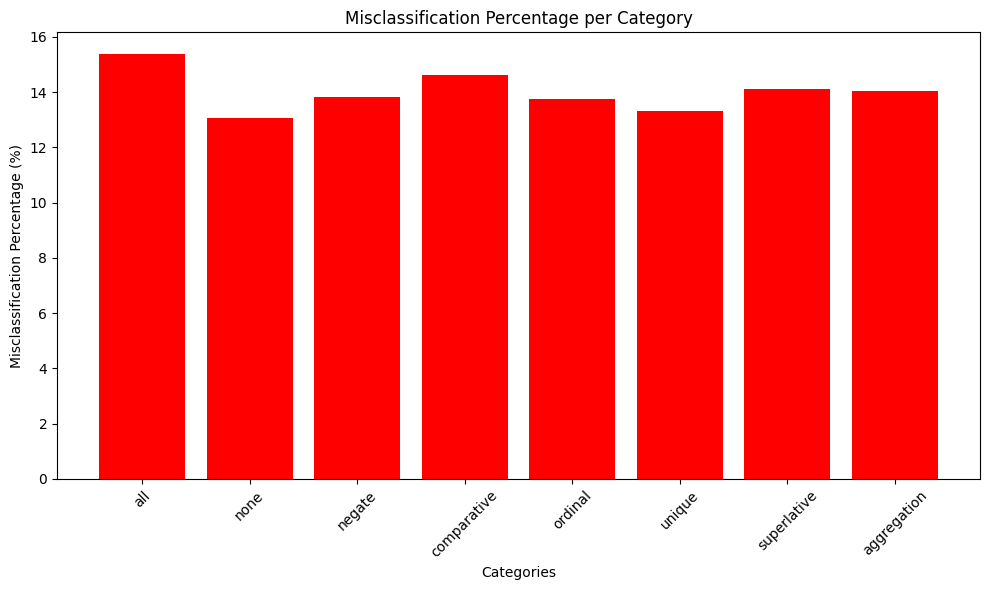

In [69]:
categorised_claims_file_name = "Error_Analysis/categorised_claims_mistral.json"
categorised_claims = load_json(categorised_claims_file_name)

their_category_misclassifications = { 
        "all": 0, "none": 0, "negate": 0, "comparative": 0, 
        "ordinal": 0, "unique": 0, "superlative": 0, "aggregation": 0
    }

our_category_misclassifications = {
    "single_attribute_verification": 0,
    "multi_attribute_conjunction": 0,
    "negation_absence_check": 0,
    "numerical_threshold_check": 0,
    "membership_association": 0,
    "aggregation_computation": 0,
    "record_existence": 0,
    "comparative_analysis": 0,
    "conditional_logic": 0
    }

our_category_misclassifications_bis = {
    "unclear_or_noisy_language": 0,
    "numerical_reasoning": 0,
    "multistep_logic": 0,
    "negation": 0
}

category_percentages = calculate_misclassifications(predictions, categorised_claims, their_category_misclassifications)
print(category_percentages)
plot_misclassifications(category_percentages)

In [ ]:
plot_misclassifications_with_overall_misclassification(predictions=predictions, category_percentages=category_percentages)

In [ ]:
category_counts = count_claims_per_category(categorised_claims)
plot_category_counts(category_counts)

In [ ]:
plot_category_cooccurrence(categorised_claims)

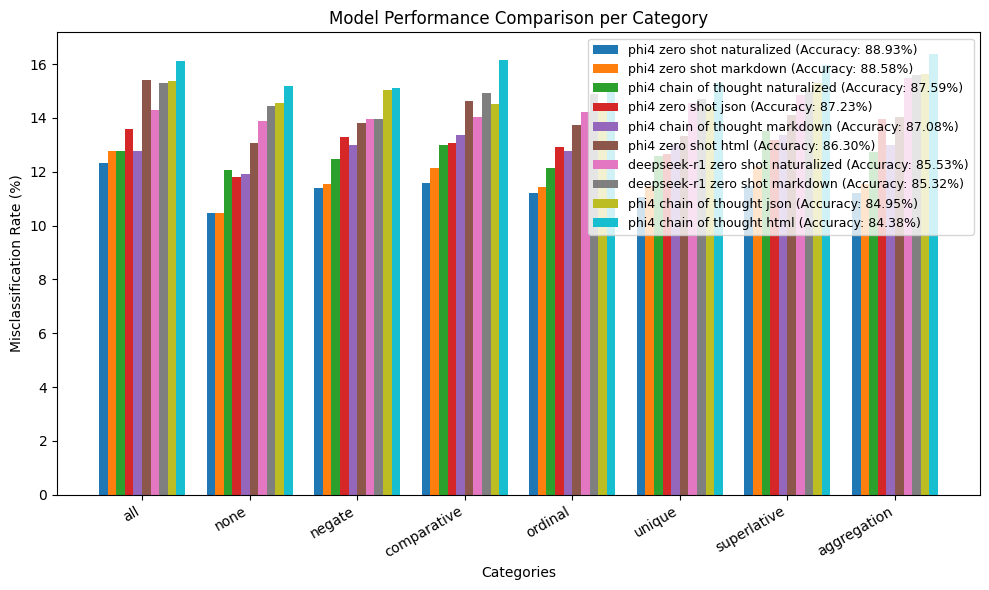

In [73]:
model_errors = []
for data in top_10_files_data:
    model_errors.append(calculate_misclassifications(data, categorised_claims, their_category_misclassifications))

plot_comparison(model_errors, top_10_accuracies_list, top_10_filenames_list)

# Helper functions

In [ ]:
def split_claims(claims_list):
    misclassified = []
    correctly_classified = []

    for claim_data in claims_list:
        if claim_data["predicted_response"] != claim_data["true_response"]:
            misclassified.append(claim_data["claim"])
        else:
            correctly_classified.append(claim_data["claim"])

    return misclassified[:50], correctly_classified[:50]

# Example usage
misclassified_claims, correctly_classified_claims = split_claims(predictions_1)
for m in misclassified_claims:
    print(m)
    print()


print("\n\nHere are correctly classified claims:\n\n")

for c in correctly_classified_claims:
    print(c)
    print()

In [74]:
def find_files_with_max_elements(path_name):
    max_elements = 0
    files_with_max_elements = []

    # Iterate through all files in the folder
    for filename in os.listdir(path_name):
        if filename.endswith('.json'):
            file_path = os.path.join(path_name, filename)
            
            # Open the JSON file and load its content
            with open(file_path, 'r') as file:
                data = json.load(file)
                
                # Check the number of objects (elements) in the list
                num_elements = len(data)
                
                # Update max_elements and the corresponding filenames
                if num_elements > max_elements:
                    max_elements = num_elements
                    files_with_max_elements = [filename]
                elif num_elements == max_elements:
                    files_with_max_elements.append(filename)

    return files_with_max_elements

# Example usage
path_name = '../docs/results'  # Replace with the path to your folder
files = find_files_with_max_elements(path_name)
print("Files with the maximum number of elements:")
for file in files:
    print(file)

Files with the maximum number of elements:
results_with_cells_deepseek-r1:8b_test_examples_1695_zero_shot_html.json
results_with_cells_deepseek-r1:8b_test_examples_1695_zero_shot_markdown.json
results_with_cells_deepseek-r1:8b_test_examples_1695_zero_shot_naturalized.json
results_with_cells_deepseek-r1:8b_test_examples_1695_zero_shot_json.json
results_with_cells_llama3.2:latest_test_examples_1695_zero_shot_html.json
results_with_cells_llama3.2:latest_test_examples_1695_zero_shot_json.json
results_with_cells_llama3.2:latest_test_examples_1695_zero_shot_markdown.json
results_with_cells_llama3.2:latest_test_examples_1695_zero_shot_naturalized.json
results_with_cells_mistral:latest_test_examples_1695_chain_of_thought_html.json
results_with_cells_mistral:latest_test_examples_1695_chain_of_thought_json.json
results_with_cells_mistral:latest_test_examples_1695_chain_of_thought_markdown.json
results_with_cells_mistral:latest_test_examples_1695_chain_of_thought_naturalized.json
results_with_cel